In [2]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the N_BaIoT dataset. 
# implemented Decision Tree Classifier. 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import time
import numpy as np


2024-05-27 22:22:57.715913: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 22:22:57.753989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 22:22:58.449642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:

df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT_Datasets/device7.csv')

# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115936 entries, 0 to 119999
Columns: 116 entries, MI_dir_L5_weight to label
dtypes: float64(115), int64(1)
memory usage: 103.5 MB


In [4]:


# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
4    20000
3    20000
6    20000
1    19623
5    18157
2    18156
Name: count, dtype: int64


In [5]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [6]:
start_time = time.time()
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier()

    start_train_time = time.time()
    # Train DT
    dt_model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    start_pred_time = time.time()    
    # Make predictions 
    y_pred_encoded = dt_model.predict(X_test)
    pred_time = time.time() - start_pred_time

total_time = time.time() - start_time

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2024-05-27 22:23:01.230832: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:2.884333 seconds
Time taken for prediction: 0.009970 seconds
Total time taken:3.075870 seconds


In [8]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9988786981397889


In [9]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred_encoded))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5887
           2       1.00      1.00      1.00      5447
           3       1.00      1.00      1.00      6000
           4       1.00      1.00      1.00      6000
           5       1.00      1.00      1.00      5447
           6       1.00      1.00      1.00      6000

    accuracy                           1.00     34781
   macro avg       1.00      1.00      1.00     34781
weighted avg       1.00      1.00      1.00     34781



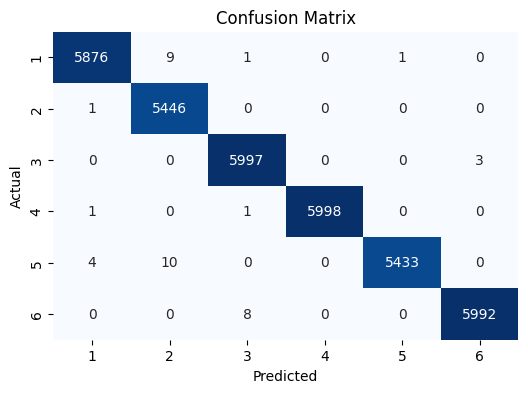

In [10]:

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred_encoded)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test, y_pred_encoded)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_1162155/2258580694.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(sorted_importance.keys()), palette='cubehelix')


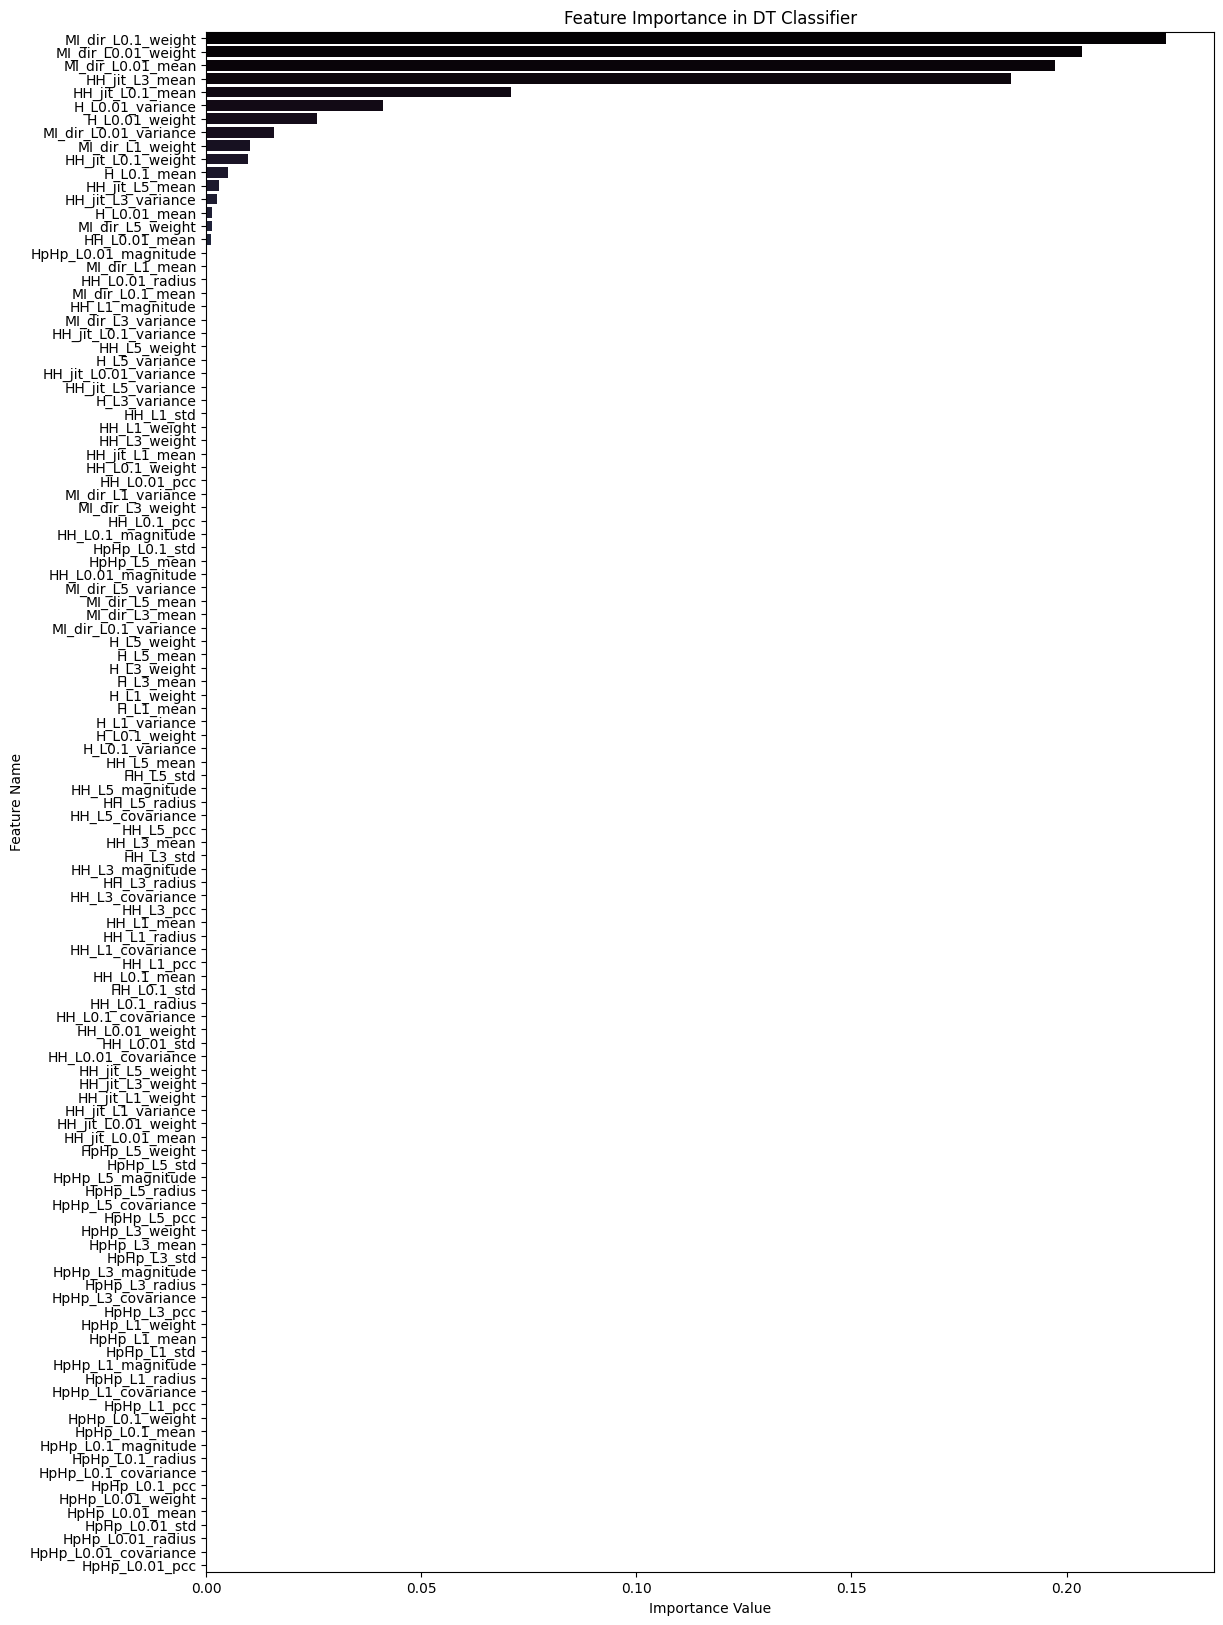

In [11]:
# importances of features in the decision tree model 
importance = dt_model.feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(13, 20))
sns.barplot(x=list(sorted_importance.values()), y=list(sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in DT Classifier')
plt.show()




In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_encoded)
precision = precision_score(y_test, y_pred_encoded, average='macro')
recall = recall_score(y_test, y_pred_encoded, average='macro')
f1 = f1_score(y_test, y_pred_encoded, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print("Prediction Evaluation:")
print("Accuracy: {:f}".format(accuracy))
print("Precision: {:f}".format(precision))
print("Recall: {:f}".format(recall))
print("F1-score: {:f}".format(f1))
print("Confusion Matrix:")
print(conf_matrix)


Prediction Evaluation:
Accuracy: 0.998879
Precision: 0.998859
Recall: 0.998869
F1-score: 0.998863
Confusion Matrix:
[[5876    9    1    0    1    0]
 [   1 5446    0    0    0    0]
 [   0    0 5997    0    0    3]
 [   1    0    1 5998    0    0]
 [   4   10    0    0 5433    0]
 [   0    0    8    0    0 5992]]
